In [1]:
Name ="Chakrya Ros"

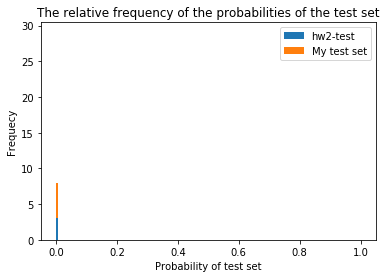

perplexity of Unigram =  42.948370488613435


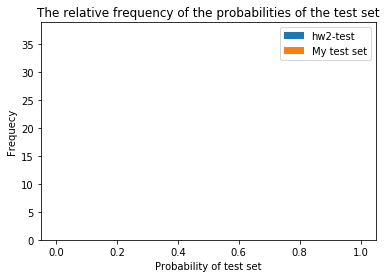

perplexity of bigram =  1907.374967806086


In [32]:
from collections import Counter
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class LanguageModel:
    def __init__(self, n_gram, is_laplace_smoothing, backoff=None):
        self.Ngram = n_gram
        self.freq = None
        self.word = None
        self.Numtokens = None
        self.smoothing = is_laplace_smoothing
        self.content = None
        self.bigram = {}
        self.unigramProb = {} # unigram probability dic
        self.bigramProb = {} # bigram probability dict
        
    def train(self, training_file_path):
        f = open(training_file_path, "r")
        self.content = f.read()
        f.close()
        self.word = self.content.split()
       
        #count the frequency word in dictionary
        self.freq = Counter(self.word)
        
        self.freq["<UNK>"] = 0
       
        #assign <UNK> to the frequecy word that less than 2
        for key, value in list(self.freq.items()):
            if value == 1:
                self.freq["<UNK>"] += 1
                del self.freq[key]
                
        # bigram frequecy word        
        for i in range(len(self.word)-1):
            if self.word[i] not in list(self.freq):  #check if the first word not in frequency
                self.word[i] = "<UNK>"
            if self.word[i+1] not in list(self.freq): #check if the next word not in frequency
                self.word[i+1] = "<UNK>"
            if (self.word[i],self.word[i+1]) not in self.bigram: #check if the first and next word not in frequency
                self.bigram[(self.word[i],self.word[i+1])] = 1
            else:
                self.bigram[(self.word[i],self.word[i+1])] += 1
        
            #calculate probability of bigram words
            self.bigramProb[(self.word[i],self.word[i+1])] = self.bigram[(self.word[i],self.word[i+1])]/sum(self.bigram.values())

        #count the number of tokens
        self.Numtokens = sum(self.freq.values())
        
        #calculate probability of each word
        for word in self.word:
            self.unigramProb[word] = self.freq[word]/sum(self.freq.values())
         
        
        

    #helper function for calculate the bigram probability for each bigram
    def bigram_prob(self,bigram):
        if self.smoothing:
            return (self.content.count('{} {}'.format(bigram[0], bigram[1])) + 1)  / (self.content.count(bigram[0]) + len(self.freq))
        else:
            return self.content.count('{} {}'.format(bigram[0], bigram[1]))  / self.content.count(bigram[0])

#     #helper function for calculate the unigram probability for each word
#     def unigram_prob(self,word):
#         return self.freq[word]/self.Numtokens
                
        
    #helper function for generate unigram random
    def unigram_generate(self):
        start = '<s>'
        word_freqs = []
        word_freqs.append(start)
      
        #check if the word is not the end of sentence
        while start != '</s>':
            unigram_freqs = {}
            #loop through frequecy words
            for w in list(self.freq.keys()):
                if w != '<s>':
                    unigram_freqs[w] = self.unigramProb[w]  #calcutate the probability bigram word
            total = sum(unigram_freqs.values())    # calcuate the total of frequence word values   
            for i in list(unigram_freqs.keys()):
                unigram_freqs[i] = unigram_freqs[i]/total
            #generate the random word in the range of probability
            random_word = random.choices(list(unigram_freqs.keys()), list(unigram_freqs.values()))
            word_freqs.append(random_word[0])
            while word_freqs[1] == '</s>':
                word_freqs.pop()
                random_word = random.choices(list(unigram_freqs.keys()), list(unigram_freqs.values()))
                word_freqs.append(random_word[0])
#             else:
#                 start = random_word[0]
            start = random_word[0]
        word_freqs = ' '.join(word_freqs)
        
        return word_freqs
    
    def bigram_genterate(self):
        start = '<s>'
        sentence = []
        sentence.append('<s>')
        #check if the word is not the end of sentence
        while start != '</s>':
            bigram_freqs = {}
            #loop through frequecy words
            for word in list(self.bigramProb.keys()):
                if word[0] == start:
                    #calcutate the probability bigram word
                    bigram_freqs[word] = self.bigramProb[word]

            total = sum(bigram_freqs.values())
            for word in bigram_freqs:
                bigram_freqs[word] = bigram_freqs[word]/total
            #random select word from bigram frequence
#             keys=np.array(list(bigram_freqs.keys()))
#             prob=np.array(list(bigram_freqs.values()))
#             prob/= prob.sum()
#             index = np.random.choice(len(keys),1,p=prob)
#             word=keys[index]
#             word=keys[np.random.choice(len(keys),1,p=prob)]
            word = random.choices(list(bigram_freqs.keys()), list(bigram_freqs.values()))
#             print("word",word)
            sentence.append(word[0][1])
#             print("sentence", sentence)
            
            start = word[0][1]

        sentence = " ".join(sentence)
        return sentence
   
            
    # generate the random sentence
    def generate(self, num_sentences):
        arr_sentences = []
        sentence = ''
        for _ in range(num_sentences):
            if self.Ngram == 1:
                sentence = self.unigram_generate() #generate the unigram sentence
            else:
                sentence = self.bigram_genterate() #generate the bigram sentence
            arr_sentences.append(sentence)
        return arr_sentences
            

       
    #calcuate the probability of each sentence
    def score(self, sentence):
        prob =1
        words = sentence.split()
        #calculate the probability of unigram
        if self.Ngram == 1:
            for i in range(len(words)):
                if words[i] not in self.freq:
                    words[i] = '<UNK>'
            for w in words:
                prob = prob * (self.freq[w]/self.Numtokens)
        #calculate the probability of bigram
        else:
            for i in range(len(words)-1):
                words[i] = (words[i], words[i+1])
            for b in words:
                prob = prob * self.bigram_prob(b)
        return prob
    
    #helper function to write probabiliy to file
    def prob_to_file(self, test_file, outfile):
        file = open(test_file)
        #read each line of file
        lines = file.readlines()
        lines.pop(-1)
        #open file to write probability to file
        out = open(outfile, 'w')
        for sentence in lines:
            #caculate the probability of unigram
            prob = self.score(sentence)
            out.write(str(prob) +"\n")
        file.close()
        out.close()
        
    def plot_histogram(self, test_file, my_test_set, savefile):
        hw_file_test = open(test_file)
        sentence_test = hw_file_test.readlines()
        prob_hw_test = []
        sentence_test.pop(-1)
        for sentence in sentence_test:
            prob_hw_test.append(self.score(sentence))
        
        myFile = open(my_test_set)
        sentence_mytest = myFile.readlines()
        prob_my_test = []
        sentence_mytest.pop(-1)
        for s in sentence_mytest:
            prob_my_test.append(self.score(s))
        hw_file_test.close()
        myFile.close()
        #plot the histogram
        plt.hist([prob_hw_test,prob_my_test], bins=np.logspace(np.log10(10**-115),
                np.log10(1.0)), label = ["hw2-test", "My test set"], stacked = True) 
        plt.title("The relative frequency of the probabilities of the test set")
        plt.xlabel("Probability of test set")
        plt.ylabel("Frequecy")
        plt.legend()
        plt.savefig(savefile,bbox_inches='tight')
        plt.show()
        
    #extra credit to calculate the perplexity
    def perplexity(self,test_sequence):
        sentence = test_sequence.split()
        NumWord = 0
        per_log_sum = 1
        if self.Ngram == 1:
            for word in sentence:
                if word in self.freq:
                    per_log_sum *= (1/self.unigramProb[word])
                    NumWord +=1
            return pow(per_log_sum, (1/float(NumWord)))
        else:
            for i in range(len(sentence)-1):
                if (sentence[i],sentence[i+1]) in self.bigram:
                    per_log_sum *= (1/self.bigramProb[sentence[i],sentence[i+1]])
                    NumWord +=1
            return pow(per_log_sum, (1/float(NumWord)))


         
                
        
def main():
    #Unigram model
    LM = LanguageModel(1, False, backoff=None)
    LM.train('berp-training.txt')
    random_sentences = LM.generate(100)
    generate_file = open("hw2-unigram-generated.txt", 'w')
    for sentence in random_sentences:
        generate_file.write(str(sentence) + '\n')
    generate_file.close()
    LM.prob_to_file("hw2-test.txt","hw2-unigram-out.txt")
    LM.plot_histogram("hw2-test.txt","hw2-my-test.txt", "hw2-unigram-histogram.pdf")
    print("perplexity of Unigram = ",LM.perplexity("<s> a wonderful day </s>"))
    
    #bigram model
    LM_bigram = LanguageModel(2, True, backoff=None)
    LM_bigram.train('berp-training.txt')
    random_bigram = LM_bigram.generate(100)
    generate_bigram = open("hw2-bigram-generated.txt", 'w')
    for sentence in random_bigram:
        generate_bigram.write(str(sentence) + '\n')
    generate_bigram.close()
    LM_bigram.prob_to_file("hw2-test.txt","hw2-bigram-out.txt")
    LM_bigram.plot_histogram("hw2-test.txt","hw2-my-test.txt", "hw2-bigram-histogram.pdf")
    print("perplexity of bigram = ",LM_bigram.perplexity("<s> a wonderful day </s>"))
        
        

                             
                
if __name__ == "__main__":
    
    main()
    
